# Spam Classification

Given that language remains a primary means of communication between humans, a lot of extremely useful data come in a natural language form. However, given its complexity and ambiguity, representing these data in a suitable form for automatic processing is a very difficult research challenge. 
We build a model to classify SMS messages for spam detection. The data was downloaded from http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

First, we need to do some text preprocessing, commonly referred to as "normalization". Text preprocessing is usually the most crucial and time-consuming part of the NLP pipeline. In this exercise, it will include the following simple steps:
1. Removing punctuation
2. Converting text to lowercase *(Side note: This step is questionable since spammers tend to use more uppercase letters)*
3. Removing stopwords (either using a predefined list of the English stopwords or using the most frequent words in the text directly)
4. Stemming or lemmatizing

Second, we represent the text in a format which can be used in machine learning. Since we will use a vector format for the messages ("documents"), this process is called "vectorization". We will use a simple "bag-of-words" (BoW) representation on a single word level (1-grams).

To classify messages as spam/ham (binary classification), we will compare three different sets of features: 
1. Length of messages only
2. Term frequencies (counts)
3. Frequency (tf-ids)


spam    4825
ham     4825
Name: type, dtype: int64
{'C': 10}
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       962
        spam       1.00      1.00      1.00       968

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930

Confusion matrix, without normalization
[[961   1]
 [  0 968]]


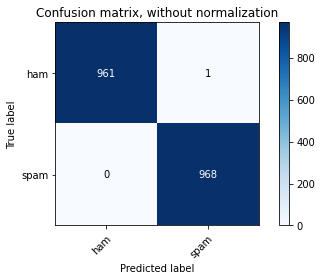

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data_df = pd.read_csv("smsspamcollection/SMSSpamCollection.txt", sep="\t", header=None, names=['type', 'message'])
data_df['message_len'] = data_df['message'].apply(len)

# Upsampling the minor class (spam)
from sklearn.utils import resample
def balance_data(df):
    # Separate majority and minority classes
    df_spam = df[df.type=='spam']
    df_ham = df[df.type=='ham'] #non-spam
    # Upsample minority class
    df_spam_upsampled = resample(df_spam, replace=True, n_samples=len(df_ham))
    # Combine majority class with upsampled minority class
    df_balanced = pd.concat([df_ham, df_spam_upsampled])
    # Display new class counts
    print(df_balanced.type.value_counts())
    return df_balanced

# Balacing the dataset
data_df = balance_data(data_df)

from sklearn.feature_extraction import _stop_words
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def text_processing(text):
    # remove punctuation 
    text = "".join([c for c in text if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() if w not in _stop_words.ENGLISH_STOP_WORDS])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

data_df['message_clean'] = data_df['message'].apply(text_processing)

#  Bag-of-words (BoW) representation. Vectorization of text messages.
#  Such vectorizers convert the whole corpora to a document-term matrix of size  𝑁×𝑀 ,
# where  𝑁  is a number of documents (messages),  𝑀  is a vocabulary size (number of different words in the corpora), 
# and each element  𝑑𝑖𝑗  corresponds to the number (or frequency, or tf-idf, etc) of the word  𝑗  in the document  𝑖 .

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(data_df['message_clean'].values)

# Term frequencies by inverse document frequency (tf-idf representation).
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)

import numpy as np
X_bow_tfidf = bow_tfidf
y = data_df['type'].apply(lambda x: 1 if x == 'spam' else 0).values
labels = np.array(['ham', 'spam'])

# train/test split
from sklearn.model_selection import train_test_split

rs = 42 # reproducible results, set to None for random
(X_bow_tfidf_train, X_bow_tfidf_test, y_train, y_test) = train_test_split( X_bow_tfidf, y,test_size=0.2 )

# Standard performance metrics such as confusion matrix and F1 score.
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

##### Function Begin #####
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
##### Function End #####

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
# **Classification using tf-idf matrix**

# Train classifier which uses the term frequencies as features. Use standard performance metrics such as confusion matrix and F1 score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), parameters, cv=5)
lr.fit(X_bow_tfidf_train, y_train)
print(lr.best_params_)

y_pred = lr.predict(X_bow_tfidf_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

# Topic modeling 

Topic modeling is a useful set of techniques to represent a document as a set of concepts (or "topics"). Conceptually, it is similar to eigenvector decomposition (Principal Component Analysis, PCA), when each data point (document) is represented as a weighted sum of different eigenvectors (topics). Topics and decompositions are learned by the algorithm in an unsupervised manner. We will use the most popular one -- Latent Dirichlet Allocation (LDA).

In [2]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

Let's run the LDA algorithm.

In [3]:
X_lda_train = lda.fit_transform(X_bow_tfidf_train)

Print top N words together with their weights in each topic

In [4]:
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

In [5]:
print("\nTopics in LDA model:")
counts_feature_names = count_vect.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in LDA model:
--------------------------------------------------------------------------------
Topic 0
0.010	cash
0.009	1000
0.008	account
0.008	customer
0.008	speak
0.007	claim
0.007	statement
0.007	service
0.007	private
0.006	point
--------------------------------------------------------------------------------
Topic 1
0.008	ok
0.008	im
0.007	ill
0.006	come
0.006	time
0.006	just
0.006	dont
0.006	ltgt
0.005	like
0.005	home
--------------------------------------------------------------------------------
Topic 2
0.006	reward
0.005	bus
0.005	hour
0.004	pas
0.004	special
0.003	cinema
0.003	brought
0.003	year
0.003	09061701461
0.003	kl341
--------------------------------------------------------------------------------
Topic 3
0.011	stop
0.011	reply
0.009	text
0.009	free
0.008	service
0.007	mobile
0.006	ringtone
0.005	ur
0.005	msg
0.005	new
--------------------------------------------------------------------------------
Topic 4
0.012	free
0.010	prize
0.009	urgent
0.007	nokia
0.007	m

**Classification using LDA**

In [6]:
X_lda_test = lda.transform(X_bow_tfidf_test)

In [7]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                  parameters, cv=5)
lr.fit(X_lda_train, y_train)
print(lr.best_params_)

{'C': 1e-09}


              precision    recall  f1-score   support

         ham       0.82      0.95      0.88       962
        spam       0.94      0.79      0.86       968

    accuracy                           0.87      1930
   macro avg       0.88      0.87      0.87      1930
weighted avg       0.88      0.87      0.87      1930

Confusion matrix, without normalization
[[916  46]
 [207 761]]


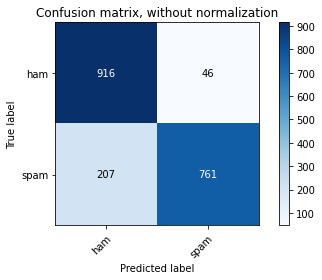

In [8]:
y_pred = lr.predict(X_lda_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

This last model does not perform as good as the previous one. However, it shows that it is possible to get very good performance using only a small number of features for each message instead of thousands of words!